<img src="https://cdn-icons-png.flaticon.com/512/5988/5988246.png" style="float: left; margin: 20px; height: 85px">

# Regression Project
## Housing Value Prediction

--- 
# Part 2 - Creating the Model

---

## Contents: 
- [<span style="font-size: 16px;"> Data Import & Classes](#Data-Import-and-Different-Classes)
- [<span style="font-size: 16px;"> Choosing the Class](#Choosing-the-Class)
- [<span style="font-size: 16px;"> Imputation Methods](#Imputation-methods)
- [<span style="font-size: 16px;"> Ridge Regularization](#Ridge-Regularization)
- [<span style="font-size: 16px;"> Lasso Regularization](#Lasso-Regularization)
- [<span style="font-size: 16px;"> Best Model](#Best-Model)
- [<span style="font-size: 16px;"> Investment Gains](#Investment-Gains)
- [<span style="font-size: 16px;"> Test for Kaggle](#Test-for-Kaggle)

In [1]:
# imports

from Train_Classes import Original, Train_Columns, Train_Outliers, Train_Zeros, X_Columns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_selector as selector
from sklearn.experimental import enable_iterative_imputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Data Import and Different Classes

In [2]:
test = pd.read_csv('datasets/test.csv')
train = pd.read_csv('datasets/train.csv')

<span style="font-size: 17px;"> Now, let's create the datasets modified according to the classes.

In [3]:
# original dataset
original = Original()
train_original = original(train)

# columns removed and columns names standardized
train_cols = Train_Columns()
train_processed = train_cols(train)

# outliers and columns removed, columns names standardized
no_outliers = Train_Outliers()
train_no_outliers = no_outliers(train)

# zeros and columns removed, columns names standardized
no_zeros = Train_Zeros()
train_no_zeros = no_zeros(train)

In [4]:
train_original.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# Choosing the Class

<span style="font-size: 16px;">First, to select between the different modifications on the original dataset, I will apply the same column transformer to all the dataset variations and the original dataset: filling null values for numerical columns with their mean and standard scaling them, and filling null values for categorical column with "missing" and one hot encoding. <br><br> After choosing the variation with the best score in cross validation score, I will try different imputation methods. In the end, Lasso and Ridge models will also be tested.

In [5]:
# numerical pipeline
num_pipe = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

<span style="font-size: 18px;">- Linear Regression on the original data
    </span><br><br>
<span style="font-size: 16px;">
    First, let us have the linear regression model on the original data as the baseline for the further improvements, due to the changes defined in the classes.

In [6]:
X = train_original.drop(['saleprice'], axis=1)
y = train_original['saleprice']

lr_original = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_original, X, y, cv = 5, scoring='r2')))

-0.2147706550354893


In [7]:
train_original.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


<span style="font-size: 18px;">- Linear Regression on the modified data

- <span style="font-size: 16px;">Filtering Columns

In [8]:
X = train_processed.drop('saleprice', axis=1)
y = train_processed['saleprice']

lr_0 = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_0, X, y, cv = 5, scoring='r2')))

0.7892630452384084


<span style="font-size: 16px;">Removing columns that had 95% or more of the observations in only one unique value and removing multicollinearity improved the model a lot.

- <span style="font-size: 16px;">Filtering Outliers

In [9]:
X = train_no_outliers.drop('saleprice', axis=1)
y = train_no_outliers['saleprice']

lr_1 = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_1, X, y, cv = 5, scoring='r2')))

0.9339743146549029


<span style="font-size: 16px;"> Removing certain outliers increased the performance of the model, leading to an R2 score of approximately 93.4!

- <span style="font-size: 16px;"> Replacing Zeros

In [10]:
X = train_no_zeros.drop('saleprice', axis=1)
y = train_no_zeros['saleprice']

lr_3 = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_3, X, y, cv = 5, scoring='r2')))

0.7799089728101295


<span style="font-size: 16px;">Replacing zeros in some features that had more than 10% of observations with 0 as value decreased the performance of the model, from the dataset variation that just selected the columns.

<span style="font-size: 17px;"> Since the variation with outliers removed had the best r2 score, I will only use that from now on.

In [11]:
# creating X and y based on chosen class
X = train_no_outliers.drop('saleprice', axis=1)
y = train_no_outliers['saleprice']

# Imputation methods

- <span style="font-size: 18px;"> Categorical Imputation

<span style="font-size: 16px;">Categorical imputation strategy of filling with 'missing' had an r2 score of approximately 0.934. <br>
    Let's try the strategy of filling with the mode.

In [12]:
# numerical pipeline
num_pipe = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

In [13]:
lr_1 = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_1, X, y, cv = 5, scoring='r2')))

0.9346214351013


- <span style="font-size: 18px;"> Numerical Imputation

<span style="font-size: 16px;">
    The strategy of filling null values of numerical columns with their mean had a r2 score of about 93.4%. Let's try filling with the mode, iterative imputer with default parameter and KNN imputer with weights = uniform and weights = distance.

<span style="font-size: 16px;"> - Mode

In [14]:
# numerical pipeline - mode imputation
num_pipe = Pipeline([
    ('imputer_num', SimpleImputer(strategy='most_frequent')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

lr_mode = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_mode, X, y, cv = 5, scoring='r2')))

0.9314653908064404


<span style="font-size: 16px;"> - Iterative Imputer

In [15]:
# numerical pipeline - iterative imputation
num_pipe = Pipeline([
    ('imputer_num', IterativeImputer(random_state=0, max_iter=15)),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

lr_iterative = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print(np.mean(cross_val_score(lr_iterative, X, y, cv = 5, scoring='r2')))

0.9338640348777794


<span style="font-size: 16px;"> - KNN Imputer

In [16]:
# numerical pipeline - iterative imputation
num_pipe = Pipeline([
    ('imputer_num', KNNImputer(n_neighbors=3, weights='uniform')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

lr_knn_uni = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)


print('Uniform weights score: ', np.mean(cross_val_score(lr_knn_uni, X, y, cv = 5, scoring='r2')))
# --

0.9335996825037514


In [17]:
# numerical pipeline - iterative imputation
num_pipe = Pipeline([
    ('imputer_num', KNNImputer(n_neighbors=3, weights='distance')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

lr_knn_dist = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func=np.exp))]
)

print('Distance weights score',np.mean(cross_val_score(lr_knn_dist, X, y, cv = 5, scoring='r2')))
# --

0.9337061492787238


> <span style="font-size: 17px;"> The numerical imputation of the beginning, SimpleImputer with 'mean' as strategy still had the best r2 score in cross validation. Next, I will test using regularization on the linear model and choose the final model.

<span style="font-size: 17px;">From now on, ColumnTransformer will be the same for all models.

In [18]:
# numerical pipeline
num_pipe = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),
    ('ss', StandardScaler())
])

# categorical pipeline
cat_pipe = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# regressor pipeline
column_transformer = ColumnTransformer([
    ("num_pipe_", num_pipe, selector(dtype_include=np.number)),
    ("cat_pipe_", cat_pipe, selector(dtype_exclude=np.number)),
], remainder = 'drop')

# Ridge Regularization

In [19]:
ridge_pipe = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=Ridge(),func=np.log, inverse_func=np.exp))]
)

In [20]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num_pipe_',
                                    Pipeline(steps=[('imputer_num',
                                                     SimpleImputer()),
                                                    ('ss', StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x29c3fd0c0>),
                                   ('cat_pipe_',
                                    Pipeline(steps=[('imputer_cat',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x29c3ff2e0>

In [21]:
ridge_cv = RandomizedSearchCV(ridge_pipe, param_distributions={'model__regressor__alpha': np.linspace(1, 100, 1000)}, scoring='r2', cv=5, random_state=0)

In [22]:
ridge_cv.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipe_',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x29c3fd0c0>),
                                                                              ('cat_pipe_',
                                                                               Pipeline(steps=[('imputer_cat',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strateg...
        97.32432432,  97.42342342,  97.52252252,  97.62162162,
        97.72072072,  97.81981982,  97.91891892,  98.01801802,
        98.11711712,  98.21621622,  98.31531532,  98.41441441,
        98.51351351,  98.61261261,  98.71171171,  98.81081081,
        98.90990991,  99.00900901,  99.10810811,  99.20720721,
        99.30630631,  99.40540541,  99.5045045 ,  99.6036036 ,
        99.7027027 ,  99.8018018 ,  99.9009009 , 100.        ])},
                   random_state=0, scoring='r2')

In [23]:
ridge_cv.score(X, y)

0.9506683476123283

In [24]:
ridge_cv.best_params_

{'model__regressor__alpha': 20.027027027027028}

# Lasso Regularization

In [25]:
lasso_pipe = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=Lasso(),func=np.log, inverse_func=np.exp))]
)

In [26]:
lasso_pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num_pipe_',
                                    Pipeline(steps=[('imputer_num',
                                                     SimpleImputer()),
                                                    ('ss', StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x29c3fd0c0>),
                                   ('cat_pipe_',
                                    Pipeline(steps=[('imputer_cat',
                                                     SimpleImputer(fill_value='missing',
                                                                   strategy='constant')),
                                                    ('ohe',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x29c3ff2e0>

In [27]:
lasso_cv = RandomizedSearchCV(lasso_pipe, param_distributions={'model__regressor__alpha': np.linspace(1, 100, 1000)}, scoring='r2', cv=5, random_state=0)

In [28]:
lasso_cv.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_pipe_',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer()),
                                                                                               ('ss',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x29c3fd0c0>),
                                                                              ('cat_pipe_',
                                                                               Pipeline(steps=[('imputer_cat',
                                                                                                SimpleImputer(fill_value='missing',
                                                                                                              strateg...
        97.32432432,  97.42342342,  97.52252252,  97.62162162,
        97.72072072,  97.81981982,  97.91891892,  98.01801802,
        98.11711712,  98.21621622,  98.31531532,  98.41441441,
        98.51351351,  98.61261261,  98.71171171,  98.81081081,
        98.90990991,  99.00900901,  99.10810811,  99.20720721,
        99.30630631,  99.40540541,  99.5045045 ,  99.6036036 ,
        99.7027027 ,  99.8018018 ,  99.9009009 , 100.        ])},
                   random_state=0, scoring='r2')

In [29]:
lasso_cv.score(X, y)

-0.034371871975410695

<span style="font-size: 17px;"> Lasso was the second worst performer, losing only to the original dataset with all features.

# Best Model

> <span style="font-size: 17px;"> Ridge Regression with an alpha of 20 was the best performer, with a r2 score mean of 95% in the cross validation score.

# Investments Gains

<span style="font-size: 17px;"> Let's train it with the whole dataset and get the predictions for the saleprice. Then, I will compare to the saleprice and consider the ones the model predicted higher prices, which might mean in gain of investments in those realty.

In [30]:
final_model = Pipeline(
    steps=[("preprocessor", column_transformer), ('model', TransformedTargetRegressor(regressor=Ridge(alpha=20),func=np.log, inverse_func=np.exp))]
)
final_model.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe_',
                                                  Pipeline(steps=[('imputer_num',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x29c3fd0c0>),
                                                 ('cat_pipe_',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x29c3ff2e0>)])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=20)))])

In [31]:
# Creating the predictions and sale price columns to see potential gains in investing in Ames Housing
investments = pd.DataFrame()
investments['predictions'] = final_model.predict(X)
investments['saleprice'] = y
investments['diff_value'] = investments['predictions'] - investments['saleprice']
investments = investments.sort_values(by='diff_value', ascending=False)

In [32]:
investments.head()

,predictions,saleprice,diff_value
1686,597209.643979,93500.0,503709.643979
1159,559690.978699,67000.0,492690.978699
820,597432.060189,132000.0,465432.060189
1222,540955.878275,97000.0,443955.878275
797,502152.287045,68000.0,434152.287045


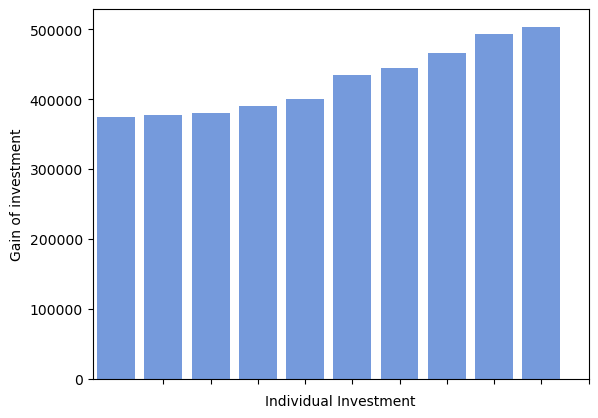

In [33]:
# Plotting the 10 most profitable investments in Ames
diff_positive = investments[investments['diff_value'] > 0].sort_values(by = 'diff_value', ascending = False)
sns.barplot(data = diff_positive[:10], x = 'diff_value', y = 'diff_value', color='cornflowerblue')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['', '', '', '','','','','','','']);
plt.xlabel('Individual Investment')
plt.ylabel('Gain of investment');

<span style="font-size: 17px;"> The realty that would lead to the greatest gains of investment in this dataset range their gains between 350000 and 500000 dollars. It is a bit strange that the actual saleprice is so much cheaper than predicted, sometimes more than 6x cheaper, so I would suggest to take a closer look at them.

> <span style="font-size: 17px;"> Nevertheless, the model had an r2 score of approximately 95% in the cross validation, which suggests it is very adequate for predicting house prices in Ames.

# Test for Kaggle

## The section below was used to predict the sale price of the test dataset to Kaggle

In [34]:
x_cols = X_Columns()
test = x_cols(test)
test.head()

,land_contour,bsmt_qual,bsmtfin_sf_2,screen_porch,lot_area,overall_qual,full_bath,totrms_abvgrd,mo_sold,exter_cond,...,year_built,bsmtfin_sf_1,gr_liv_area,sale_type,house_style,mas_vnr_area,total_bsmt_sf,wood_deck_sf,yr_sold,id
0,Lvl,Fa,0,0,9142,6,2,9,4,Fa,...,1910,0,1928,WD,2Story,0.0,1020,0,2006,2658
1,Lvl,Gd,0,0,9662,5,2,10,8,TA,...,1977,0,1967,WD,1Story,0.0,1967,170,2006,2718
2,Lvl,Gd,0,0,17104,7,2,7,9,TA,...,2006,554,1496,New,2Story,0.0,654,100,2006,2414
3,Lvl,TA,0,0,8520,5,1,5,7,TA,...,1923,0,968,WD,1Story,0.0,968,0,2007,1989
4,Lvl,Gd,0,185,9500,6,1,6,7,TA,...,1963,609,1394,WD,1Story,247.0,1394,0,2009,625


In [35]:
predictions = final_model.predict(test)
test['saleprice'] = predictions

In [36]:
submission = test[['id', 'saleprice']]
submission.columns = ['Id', 'SalePrice']
submission.set_index('Id', inplace = True)
submission.to_csv('mar15_sub.csv')